In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

### Load a random image for tests

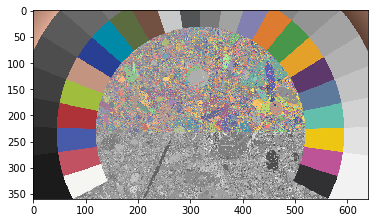

In [2]:
img = imageio.imread("chart.png")
h, w = img.shape[:-1]
plt.imshow(img)

## Spectrum simulation

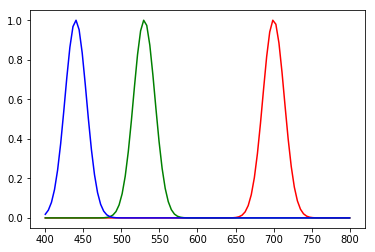

In [3]:
# Peak wavelenght values pour r, g, b
r, g, b = (700, 530, 440)
# Consider wavelengths from 400nm to 800nm
dom = np.linspace(400, 800, 100)

# build normal distribution centered around peak wavelengths

sig = 200
red = 1/(2*np.pi*sig) * np.exp(-((dom-r)**2)/(2*sig))
blue = 1/(2*np.pi*sig) * np.exp(-((dom-b)**2)/(2*sig))
green = 1/(2*np.pi*sig) * np.exp(-((dom-g)**2)/(2*sig))

# Normalize values
red/=np.max(red)
green/=np.max(green)
blue/=np.max(blue)

#Multiply each channel of each pixel with its corresponding photon distribution, and sum the channels
spectrum = np.einsum('ij,k->ijk',img[:, :, 0].astype(float) , red) + \
            np.einsum('ij,k->ijk',img[:, :, 1].astype(float) , green) +\
            np.einsum('ij,k->ijk',img[:, :, 2].astype(float) , blue)
                      
plt.plot(dom, red, 'r')
plt.plot(dom, green, 'g')
plt.plot(dom, blue, 'b')

## Transform pixels

pixel (1, 1): , r: 171, g: 128, b: 110


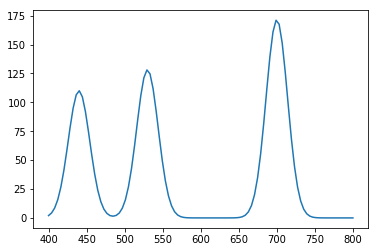

In [4]:
# Result of the transformation
print('pixel (1, 1): , r: %s, g: %s, b: %s' % (img[1, 1, 0], img[1, 1, 1], img[1, 1, 2]))
plt.plot(dom, spectrum[1, 1, :])

## QE

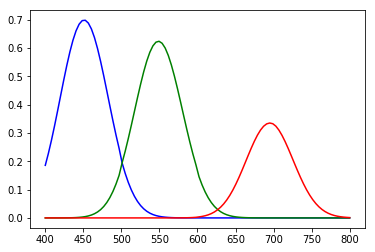

In [5]:
from emva1288.camera import Camera
from emva1288.camera.routines import Qe, get_bayer_filter

#Create a bayer filter (See emva1288 docs)
filt = get_bayer_filter(450, 550, 550, 700, w, h, dom)
#Create qe object base on filter and image size
qe = Qe(filter=filt, width=w, height=h)
#Initialize camera (See emva1288 docs)
cam = Camera(qe=qe, width=w, height=h)

plt.plot(dom, qe.qe[0,0], 'b')
plt.plot(dom, qe.qe[1,0], 'g')
plt.plot(dom, qe.qe[1,1], 'r')

## Grab

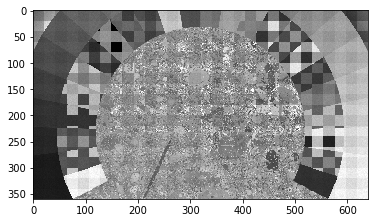

In [6]:
# Use get_radiance_for to have a reasonnable number of photons that hit the sensor
factor = np.mean(cam.get_radiance_for(100))/np.mean(spectrum)
cap = cam.grab(factor * spectrum)
plt.imshow(cap, cmap='gray')

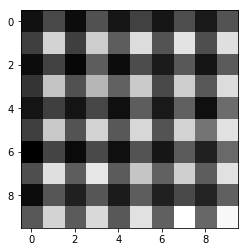

In [7]:
plt.imshow(cap[:10,:10], cmap='gray')

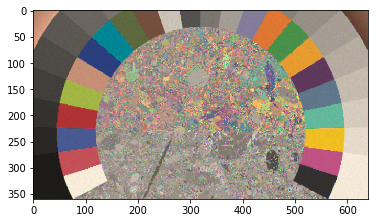

In [8]:
import cv2
# Debayering
colour1 = cv2.cvtColor(cap, cv2.COLOR_BAYER_BG2BGR)
plt.imshow(colour1)

Use with other parameters

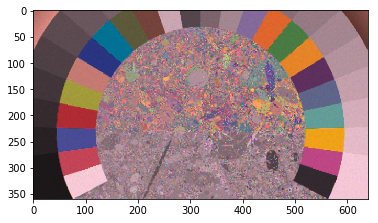

In [9]:
#Change qe slightly and repeat
filt = get_bayer_filter(430, 560, 560, 710, w, h, dom)
qe = Qe(filter=filt, width=w, height=h)
cam = Camera(qe=qe, width=w, height=h)
# Use get_radiance_for to have a reasonnable number of photons that hit the sensor
factor = np.mean(cam.get_radiance_for(100))/np.mean(spectrum)
cap = cam.grab(factor * spectrum)
#Debayering
colour2 = cv2.cvtColor(cap, cv2.COLOR_BAYER_BG2BGR)

plt.imshow(colour2)
plt.show()

In [10]:
%%timeit
cap = cam.grab(factor * spectrum)

244 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
